# Simulate the data

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import dirichlet, multinomial
from scipy.sparse import lil_matrix
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

np.random.seed(37)

# number of topics
K = 10
# number of words
N = 100
# number of documents
M = 1000

# priors on K topics
a = np.array([0.1, 0.2, 0.3, 0.4, 0.025, 0.015, 0.37, 0.88, 0.03, 0.08])
# priors on N words
b = np.full((1, N), 0.001, dtype=float)[0]

# distribution of words in topic k
psi = np.array([dirichlet.rvs(b)[0] for _ in range(K)])

# distribution of topics in document d
theta = np.array([dirichlet.rvs(a)[0] for _ in range(M)])

# simulate the documents
texts = []
docs = []
for i in range(M):
    d = {}
    t = []
    for j in range(N):
        z_ij = multinomial.rvs(1, theta[i] / theta[i].sum())
        topic = np.argmax(z_ij)
        
        w_ij = multinomial.rvs(1, psi[topic] / psi[topic].sum())
        word = np.argmax(w_ij)
        
        if word not in d:
            d[word] = 0
        d[word] = d[word] + 1
        t.append('w{}'.format(word))
    docs.append(d)
    texts.append(' '.join(t))

# make a nice matrix
C = lil_matrix((M, N), dtype=np.int16)
for i, d in enumerate(docs):
    counts = sorted(list(d.items()), key=lambda tup: tup[0])
    for tup in counts:
        C[i, tup[0]] = tup[1]
        
X = TfidfTransformer().fit_transform(C)

# Gaussian mixture models

In [2]:
from scipy.sparse.linalg import svds
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=200, random_state=37)
    gmm.fit(X)
    aic = gmm.aic(X)
    print('{}: aic={}'.format(k, aic))
    return k, aic

U, S, V = svds(X, k=20)
gmm_scores = [get_gmm_labels(U, k) for k in range(2, 26)]

2: aic=-91377.4925931899
3: aic=-115401.48064693023
4: aic=-140093.33933540553
5: aic=-140323.78987370024
6: aic=-141875.76088708825
7: aic=-148775.55233751613
8: aic=-144864.34044251216
9: aic=-145063.49226211055
10: aic=-150715.1903769901
11: aic=-152996.52348895653
12: aic=-155759.24880410856
13: aic=-154738.52657589086
14: aic=-155298.35704192414
15: aic=-155273.86266190925
16: aic=-158229.54424744606
17: aic=-158801.9282636591
18: aic=-158146.93107164896
19: aic=-157399.8820983792
20: aic=-158964.20247723104
21: aic=-156443.29839085328
22: aic=-156545.2892447556
23: aic=-156265.51016605442
24: aic=-155860.49143508542
25: aic=-157396.56289736537


# k-means clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_kmc(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    print('{}: score={}'.format(k, score))
    return k, score

kmc_scores = [get_kmc(X, k) for k in range(2, 26)]

2: score=0.22136552497539078
3: score=0.2606191325546754
4: score=0.2985364557161296
5: score=0.32764563696557253
6: score=0.34711980577628615
7: score=0.36212754809252495
8: score=0.3693035922796191
9: score=0.3118628444238988
10: score=0.32070416934016466
11: score=0.3056882384904699
12: score=0.28297903762485543
13: score=0.28462816984240946
14: score=0.2747613933318139
15: score=0.2787478862359055
16: score=0.27452088253304896
17: score=0.2548015324435892
18: score=0.25961952207924777
19: score=0.25650479556223627
20: score=0.251690199350559
21: score=0.2566617758778615
22: score=0.25866268014756943
23: score=0.24607465357359543
24: score=0.24936289940720038
25: score=0.2579644562276278


# LDA modeling

In [4]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def learn_lda_model(corpus, dictionary, k):
    lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=k, 
               random_state=37, 
               iterations=100,
               passes=5,
               per_word_topics=False)
    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print('{}: {}'.format(k, coherence))
    return k, coherence

T = [t.split(' ') for t in texts]

dictionary = corpora.Dictionary(T)
corpus = [dictionary.doc2bow(text) for text in T]

lda_scores = [learn_lda_model(corpus, dictionary, k) for k in range(2, 26)]

2: -7.112621491925517
3: -6.770771537876562
4: -6.654850158110881
5: -6.495525290205532
6: -6.592127872424598
7: -6.4394384370150854
8: -6.431505215171467
9: -6.376827700591723
10: -6.207008469326988
11: -6.235774265382583
12: -6.260016126133871
13: -6.254881861190534
14: -6.550148968159432
15: -6.6008249817300415
16: -6.560176401338963
17: -6.59075565762325
18: -6.766128087354434
19: -6.781869098089526
20: -6.769066694113159
21: -6.8683429580215165
22: -6.6622351856878375
23: -6.773847370134338
24: -6.735329093161339
25: -6.676802294304821


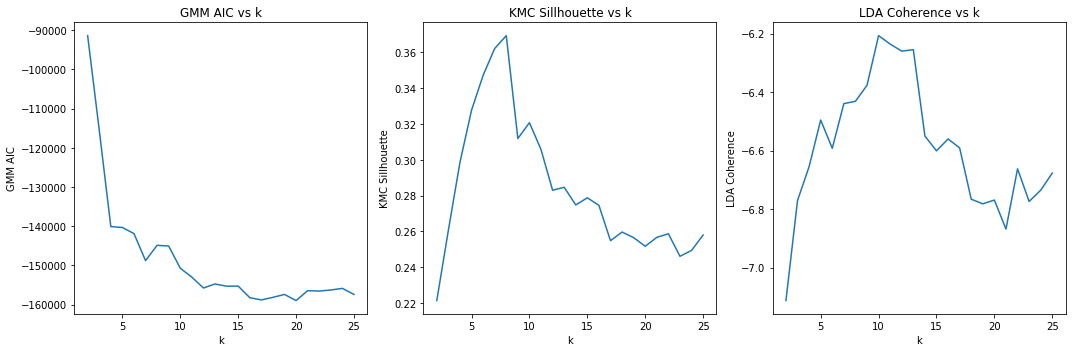

In [5]:
def plot_scores(scores, ax, ylabel):
    _x = [s[0] for s in scores]
    _y = [s[1] for s in scores]

    ax.plot(_x, _y, color='tab:blue')
    ax.set_xlabel('k')
    ax.set_ylabel(ylabel)
    ax.set_title('{} vs k'.format(ylabel))
    
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_scores(gmm_scores, ax[0], 'GMM AIC')
plot_scores(kmc_scores, ax[1], 'KMC Sillhouette')
plot_scores(lda_scores, ax[2], 'LDA Coherence')

plt.tight_layout()

In [6]:
import pyLDAvis.gensim
import warnings

warnings.filterwarnings('ignore')

lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=10, 
               random_state=37, 
               iterations=100,
               passes=5,
               per_word_topics=False)

lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/super/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


# Example

In [7]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

def clean(text):
    t = text.lower().strip()
    t = t.split()
    t = remove_stop_words(t)
    t = [get_lemma(w) for w in t]
    t = [get_stem(w) for w in t]
    return t

def get_stem(w):
    return PorterStemmer().stem(w)
    
def get_lemma(w):
    lemma = wn.morphy(w)
    return w if lemma is None else lemma
    
def remove_stop_words(tokens):
    stop_words = nltk.corpus.stopwords.words('english')
    return [token for token in tokens if token not in stop_words]


texts = [
    'The Art of Computer Programming',
    'Computer Programming Learn Any Programming Language In 2 Hours',
    'The Self-Taught Programmer The Definitive Guide to Programming Professionally',
    'The Complete Software Developers Career Guide How to Learn Your Next Programming Language',
    'Cracking the Coding Interview 189 Programming Questions and Solutions',
    'The Economics Book Big Ideas Simply Explained',
    'Economics in One Lesson The Shortest and Surest Way to Understand Basic Economics',
    'Basic Economics',
    'Aftermath Seven Secrets of Wealth Preservation in the Coming Chaos',
    'Economics 101 From Consumer Behavior to Competitive Markets Everything You Need to Know About Economics'
]

texts = [clean(t) for t in texts]

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_scores = [learn_lda_model(corpus, dictionary, k) for k in range(2, 10)]

2: -26.8263021597115
3: -26.863492751597203
4: -26.88208804754005
5: -26.848616514842924
6: -26.9006833434829
7: -26.874118634993117
8: -26.88208804754005
9: -26.863492751597203


In [8]:
lda = LdaModel(corpus, 
               id2word=dictionary, 
               num_topics=2, 
               random_state=37, 
               iterations=100,
               passes=20,
               per_word_topics=False)
corpus_lda = lda[corpus]

In [9]:
for d in corpus_lda:
    print(d)

[(0, 0.25178075), (1, 0.74821925)]
[(0, 0.16788821), (1, 0.8321118)]
[(0, 0.25178382), (1, 0.74821615)]
[(0, 0.2517796), (1, 0.7482204)]
[(0, 0.25178117), (1, 0.74821883)]
[(0, 0.748248), (1, 0.25175205)]
[(0, 0.83213073), (1, 0.16786923)]
[(0, 0.7482476), (1, 0.25175238)]
[(0, 0.5), (1, 0.5)]
[(0, 0.8321299), (1, 0.16787016)]


In [10]:
lda.print_topics()

[(0, '0.926*"econom" + 0.074*"program"'),
 (1, '0.926*"program" + 0.074*"econom"')]

In [11]:
lda[dictionary.doc2bow(clean('Naked Economics Undressing the Dismal Science'))]

[(0, 0.7482481), (1, 0.2517519)]

In [12]:
lda[dictionary.doc2bow(clean('Elements of Programming Interviews in Python The Insiders Guide'))]

[(0, 0.2517816), (1, 0.7482184)]

In [13]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)